In [94]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

In [109]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
# reusing code from - https://towardsdatascience.com/running-xgboost-on-google-colab-free-gpu-a-case-study-841c90fef101

In [2]:
# Read data in
cust_data_pd = pd.read_csv('/content/CUST_DATASET_ST.csv')
fsa_data_pd = pd.read_csv('/content/FSA_DATASET_ST.csv')
mg_data_pd = pd.read_csv('/content/MG_DATASET_ST.csv')

In [9]:
# Get ratio of default to no
mg_data_pd.groupby('default').agg('count')

,mg_acc,FSA,origin_date,property_type,purchase_price,amort_period,loan_size,interest_rate,TDS,Sample
default,,,,,,,,,,
0.0,3326,3326,3326,3326,3326,3326,3326,3326,3326,3326
1.0,983,983,983,983,983,983,983,983,983,983


In [22]:
# Look at distribution of FSA codes across mortgage holders
mg_data_pd.groupby('FSA').FSA.agg('count')

FSA
V0A    26
V0B    46
V0C    37
V0E    79
V0G    50
       ..
V9V    17
V9W    47
V9X    19
V9Y    47
V9Z    48
Name: FSA, Length: 183, dtype: int64

In [25]:
# Lets join mortgage data with customer data
mg_w_cust_dat_pd = mg_data_pd.merge(cust_data_pd, on='mg_acc', how='left')

In [33]:
# Now lets join FSA to the merged_data
all_dat_pd = mg_w_cust_dat_pd.merge(fsa_data_pd, on='FSA', how='left')

In [40]:
# Add a predictor that computes Loan to value ratio
all_dat_pd['LTR'] = all_dat_pd['purchase_price'] / all_dat_pd['loan_size']

In [44]:
# Convert date column into datetime obj
all_dat_pd['origin_date'] = pd.to_datetime(all_dat_pd['origin_date'], format="%Y-%m-%d")

In [47]:
# Add dummy variables to dataframe
dummy_cols = ['property_type', 'amort_period']
all_dat_w_dummies_pd = pd.get_dummies(all_dat_pd, columns=dummy_cols)

In [53]:
# Remove holdout samples
train_dat_pd = all_dat_w_dummies_pd[all_dat_w_dummies_pd.Sample != 'Holdout']

In [54]:
# Check
train_dat_pd.groupby('Sample').Sample.agg('count')

Sample
Estimation    3748
Validation    1891
Name: Sample, dtype: int64

In [83]:
# Drop join cols to create for feature matrix
drop_cols = ['mg_acc', 'FSA', 'default', 'Sample', 'cust_age', 'cust_gender', 'origin_date']
features_pd = train_dat_pd.drop(columns=drop_cols)

# Create a target column that is categorical/binary
target = train_dat_pd['default']
cat_col = pd.Categorical(target)
target = pd.Series(cat_col.codes)

In [84]:
# split the clean_X into train and test sets
seed = 1958
X_train, X_test, y_train, y_test = train_test_split(features_pd, target, test_size=0.20, 
                                                    random_state=seed, shuffle=True, stratify=target)

In [85]:
import time
from xgboost import XGBClassifier# create a default XGBoost classifier
model = XGBClassifier(n_estimators=500, random_state=seed)# define the eval set and metric

eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]# fit the model
%time model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

CPU times: user 6.41 s, sys: 29.2 ms, total: 6.44 s
Wall time: 6.54 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1958,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [91]:
# final model assessment
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))

print('Classification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.8907115938816227
Test Accuraccy:  0.7810283687943262
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       864
           1       0.58      0.23      0.33       264

    accuracy                           0.78      1128
   macro avg       0.69      0.59      0.60      1128
weighted avg       0.75      0.78      0.74      1128



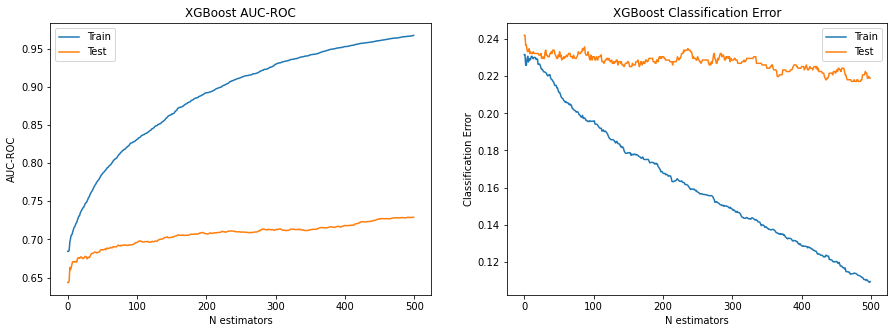

<Figure size 432x288 with 0 Axes>

In [95]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(1, 2, figsize=(15,5))# plot auc
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost AUC-ROC')
ax[0].set_ylabel('AUC-ROC')
ax[0].set_xlabel('N estimators')# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost Classification Error')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('N estimators')
plt.show()
plt.tight_layout()

In [106]:
# create a default XGBoost classifier
model = XGBClassifier(
    random_state=seed, 
    eval_metric=["error", "auc"]
)

# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, 0.01],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 500, 600],
    "reg_lambda": [1, 1.5, 2]
}

scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}

# create the Kfold object
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)

# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)

# fit grid search
%time best_model = grid.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


CPU times: user 8.3 s, sys: 120 ms, total: 8.42 s
Wall time: 9min 37s


In [107]:
print(f'Best score: {best_model.best_score_}')
print(f'Best model: {best_model.best_params_}')

Best score: 0.7285148733606859
Best model: {'subsample': 1.0, 'reg_lambda': 1.5, 'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.1}


In [110]:
# Asses best model's performance on hold out test set
pred_test = best_model.predict(X_test)
pred_train = best_model.predict(X_train)

print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, pred_test))

print('\nClassification Report:')
print(classification_report(y_test, pred_test))

Train Accuracy:  0.9691864331633784
Test Accuraccy:  0.7898936170212766

Confusion Matrix:
[[812  52]
 [185  79]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       864
           1       0.60      0.30      0.40       264

    accuracy                           0.79      1128
   macro avg       0.71      0.62      0.64      1128
weighted avg       0.76      0.79      0.76      1128



In [155]:
# Get best model's predictions for holdout set
holdout_pd = all_dat_w_dummies_pd[all_dat_w_dummies_pd.Sample == 'Holdout']

# Drop join cols to create for feature matrix
drop_cols = ['mg_acc', 'FSA', 'default', 'Sample', 'cust_age', 'cust_gender', 'origin_date']
H_test = holdout_pd.drop(columns=drop_cols)

# Remove dropped cols from holdout features
pred_holdout_label = best_model.predict(H_test)
pred_holdout_probs = best_model.predict_proba(H_test)

In [160]:
default_probs = [x[1] for x in pred_holdout_probs.tolist()]

In [162]:
# Add model predictions to dataset with account ids
holdout_pd.loc[:, 'pred_labels'] = pred_holdout_label.tolist()
holdout_pd.loc[:, 'pred_probs'] = default_probs

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [164]:
# Use the highest prediction for an mg account to determine if an account holder will default
H_pred = holdout_pd.groupby('mg_acc').agg('max')

In [165]:
# Summarize predictions
H_pred.loc[:, 'mg_acc'] = H_pred.index
H_pred_small = H_pred

In [174]:
# Append predictions with mortgage ids
keep_cols = ['mg_acc', 'pred_probs', 'pred_labels']
final_preds = H_pred_small[keep_cols].reset_index(drop=True)

In [176]:
final_preds.to_csv('/content/final_predictions.csv')

In [173]:
H_pred_small[keep_cols].reset_index(drop=True)

,mg_acc,pred_probs,pred_labels
0,213,0.205600,0
1,488,0.092516,0
2,629,0.477980,0
3,947,0.034681,0
4,1393,0.002521,0
...,...,...,...
1467,997718,0.513627,1
1468,997822,0.382809,0
1469,998560,0.318740,0
1470,998830,0.208692,0


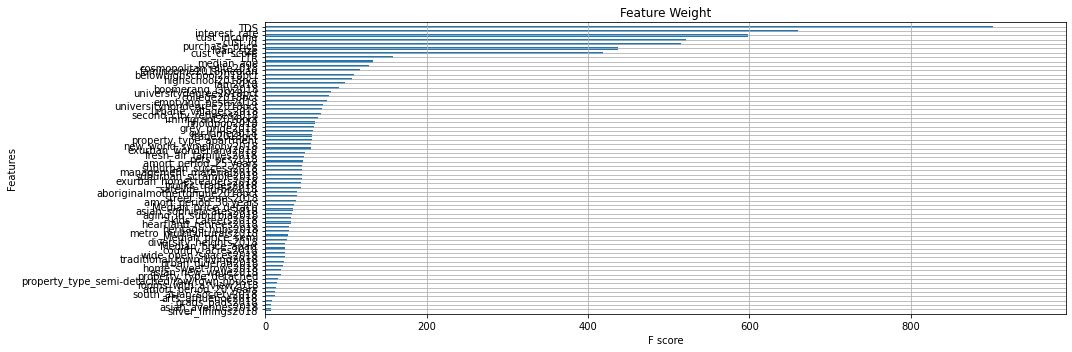

In [184]:
# store the winning model in a new variable
xgc = best_model.best_estimator_

# saving the feature names to the model
xgc.get_booster().feature_names = features_pd.columns.to_list()

# Create the feature importances plot
fig, ax = plt.subplots(figsize=(15,5))

# plot importances with feature weight
xgb.plot_importance(
    booster=xgc, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax,
)

# plot importances with split mean gain
# xgb.plot_importance(
#     booster=xgc,
#     importance_type='gain',
#     title='Split Mean Gain',
#     show_values=False,
#     height=0.5,
#     ax=ax[1]
# )

# plot importances with sample coverage
# xgb.plot_importance(
#     xgc,
#     importance_type='cover',
#     title='Sample Coverage',
#     show_values=False,
#     height=0.5,
#     ax=ax[2]
# )
plt.tight_layout()
plt.savefig('/content/feature_importance.png')